In [1]:
mp_pdf = False
import matplotlib
if mp_pdf:
    matplotlib.use('pgf')   
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [3.5,5]
    }
    matplotlib.rcParams.update(pgf_with_latex)
    extension="pdf"
else:
    extension="png"
    
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
import pickle
from django.db.models import Count, Sum
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize



In [2]:
q = Query.objects.get(pk=6187)

In [3]:
import nltk
from nltk.stem import SnowballStemmer

stoplist = set(nltk.corpus.stopwords.words("english"))
stoplist.add('elsevier')
stoplist.add('rights')
stoplist.add('reserved')
stoplist.add('john')
stoplist.add('wiley')
stoplist.add('sons')
stoplist.add('copyright')

stopwords = stoplist

def lemmatize(token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)

kws = Doc.objects.filter(
    query=q,
    kw__text__iregex='\W'
).values('kw__text').annotate(
    n = Count('pk')
).filter(n__gt=100).order_by('-n')

kw_text = set([x['kw__text'].replace('-',' ') for x in kws])
kw_ws = set([x['kw__text'].replace('-',' ').split()[0] for x in kws]) - stopwords

def tokenize(X):
    for sent in sent_tokenize(X):
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            token = token.lower().strip()
            if token in stopwords:
                continue
            if all(char in punct for char in token):
                continue
            if len(token) < 3:
                continue
            if all(char in string.digits for char in token):
                continue
            lemma = lemmatize(token,tag)
            yield lemma

def fancy_tokenize(X):
    common_words = set([x.lower() for x in X.split()]) & kw_ws
    for w in list(common_words):
        w = w.replace('(','').replace(')','')
        wpat = "({}\W*\w*)".format(w)
        wn = [x.lower().replace('-',' ') for x in re.findall(wpat, X, re.IGNORECASE)]
        kw_matches = set(wn) & kw_text
        if len(kw_matches) > 0:
            for m in kw_matches:
                insensitive_m = re.compile(m, re.IGNORECASE)
                X = insensitive_m.sub(' ', X)
                yield m.replace(" ","-")

    for sent in sent_tokenize(X):
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            token = token.lower().strip()
            if token in stopwords:
                continue
            if all(char in punct for char in token):
                continue
            if len(token) < 3:
                continue
            if all(char in string.digits for char in token):
                continue
            lemma = lemmatize(token,tag)
            yield lemma

<Container object of 2 artists>

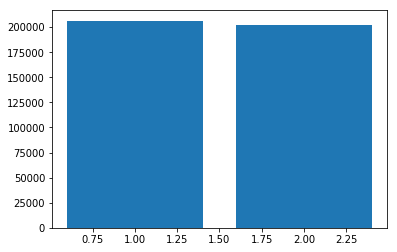

In [4]:
q = Query.objects.get(pk=6187)

before = q.doc_set.filter(PY__lt=2014).count()

since = q.doc_set.filter(PY__gte=2014).count()

fig, ax = plt.subplots()

ax.bar(
    [1,2],
    [before,since]
)

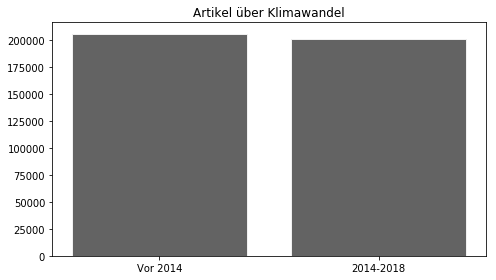

In [5]:
fig, ax = plt.subplots(figsize=(7,4))

ax.bar(
    [1,2],
    [before,since],
    edgecolor="#F0F0F0",
    color="#636363",
    linewidth=1
)

ax.set_xticks([1,2])
ax.set_xticklabels(["Vor 2014", "2014-2018"])

ax.set_title("Artikel über Klimawandel")

fig.tight_layout()

plt.savefig("../plots/before_since_AR5.pdf")

plt.show()

In [6]:
ars = AR.objects.filter(ar__gt=0).order_by('ar').values('name','start','end')

for ar in ars:
    ar["years"] = f'{ar["start"]}-{ar["end"]}'
    if ar["name"] == "AR6":
        ar["years"] = f'{ar["start"]}-'

ardf = pd.DataFrame.from_dict(list(ars))[['name','years']]

ardf.to_latex("../tables/ar_years.tex",index=False)
#ardf['years'] = f"-{ardf['start']}"
ardf.head(6)


,name,years
0,AR1,1986-1989
1,AR2,1990-1994
2,AR3,1995-2000
3,AR4,2001-2006
4,AR5,2007-2013
5,AR6,2014-


In [7]:
bypy = Doc.objects.filter(query=q,PY__lt=2019).values('PY').annotate(
    n = Count('pk')
)
def get_ar(x):
    for ar in AR.objects.order_by('ar'):
        if x >= ar.start and x <= ar.end:
            return ar.name

pydf = pd.DataFrame.from_dict(list(bypy))
pydf['AR'] = pydf['PY'].apply(lambda x: get_ar(x))
pydf.head()

,PY,n,AR
0,1900,1,AR0
1,1903,1,AR0
2,1904,1,AR0
3,1905,1,AR0
4,1907,1,AR0


369535.7904682656


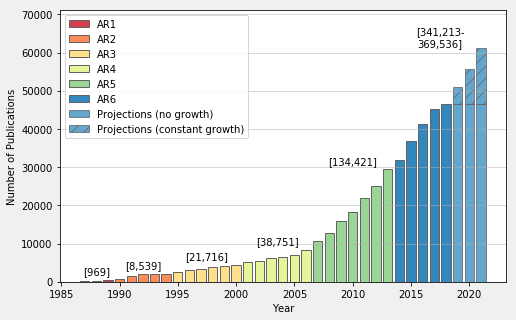

In [8]:
fig, ax = plt.subplots(figsize=(8,5))

colors = dict(zip(
    AR.objects.filter(ar__gt=0).order_by('ar').values_list('name',flat=True),
    ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd']
))


pdf = pydf[pydf['PY']>1986].sort_values('PY').reset_index(drop=True)

def CAGR(first, last, periods):
    try:
        return (last/first)**(1/periods)-1
    except:
        return np.nan
    
pdf['lag_5'] = pdf['n'].shift(5)
pdf['CAGR_5'] = pdf.apply(lambda x: CAGR(x['lag_5'], x['n'] ,5), axis=1)


ec = "#636363"
for name, group in pdf.groupby('AR'):
    group = group.reset_index(drop=True)
    ax.bar(
        group['PY'],
        group['n'],
        color=[colors[x] for x in group['AR']],
        edgecolor=ec,
        label=name
    )
    mid = group['PY'].median()
    max_n = group['n'].max() + 800
    sum_n = group['n'].sum()
    if name=="AR6":
        continue
    ax.text(mid, max_n, f"[{sum_n:,}]", ha="center", va="bottom")
    
ax.set_ylim(0,max_n+5000)
    
last_recorded = pdf['n'].iloc[-1]
last = last_recorded
grate = pdf['CAGR_5'].iloc[-1]
projections=0
ar6_total = sum_n
ar6_nogrowth = sum_n
fyears = [2019, 2020, 2021]

for py in fyears:
    if py==2019:
        name_ng = "Projections (no growth)"
        name_cg = "Projections (constant growth)"
    else:
        name_ng = None
        name_cg = None
    ax.bar(
        py,
        last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        label=name_ng,
        alpha=0.75
    )
    growth = last*grate
    projections+=growth
    ax.bar(
        py,
        projections,
        bottom=last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        hatch="//",
        label=name_cg,
        alpha=0.75
    )    
    last = last+growth
    max_n = last
    ar6_total +=last
    ar6_nogrowth +=last_recorded
    #new = last*pdf['CAGR_5'][-1]
    
print(ar6_total)

mid = pd.concat([group['PY'], pd.Series(fyears)]).median()
label = f"[{ar6_nogrowth:,}-\n{int(round(ar6_total)):,}]"
ax.text(mid, max_n, label, ha="center", va="bottom")
            
ax.set_ylim(0,max_n+10000)
ax.grid(linestyle='-', linewidth=0.5,axis="y")

ax.set_xlabel("Year")
ax.set_ylabel("Number of Publications")

plt.legend()
            
fig.patch.set_facecolor('#f0f0f0') 

    
plt.savefig(
    f'../plots/literature_size/pubs_time.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.savefig(
    f'../plots/literature_size/pubs_time.svg',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.show()

369535.7904682656


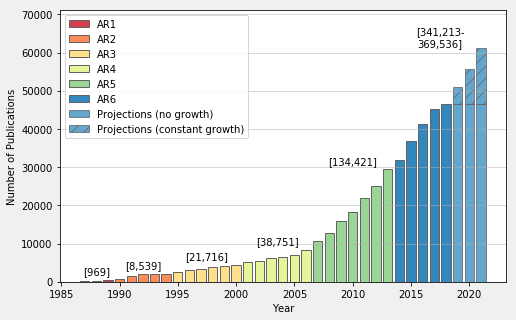

In [9]:
fig, ax = plt.subplots(figsize=(8,5))

colors = dict(zip(
    AR.objects.filter(ar__gt=0).order_by('ar').values_list('name',flat=True),
    ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd']
))


pdf = pydf[pydf['PY']>1986].sort_values('PY').reset_index(drop=True)

def CAGR(first, last, periods):
    try:
        return (last/first)**(1/periods)-1
    except:
        return np.nan
    
pdf['lag_5'] = pdf['n'].shift(5)
pdf['CAGR_5'] = pdf.apply(lambda x: CAGR(x['lag_5'], x['n'] ,5), axis=1)


ec = "#636363"
for name, group in pdf.groupby('AR'):
    group = group.reset_index(drop=True)
    ax.bar(
        group['PY'],
        group['n'],
        color=[colors[x] for x in group['AR']],
        edgecolor=ec,
        label=name
    )
    mid = group['PY'].median()
    max_n = group['n'].max() + 800
    sum_n = group['n'].sum()
    if name=="AR6":
        continue
    ax.text(mid, max_n, f"[{sum_n:,}]", ha="center", va="bottom")
    
ax.set_ylim(0,max_n+5000)
    
last_recorded = pdf['n'].iloc[-1]
last = last_recorded
grate = pdf['CAGR_5'].iloc[-1]
projections=0
ar6_total = sum_n
ar6_nogrowth = sum_n
fyears = [2019, 2020, 2021]

for py in fyears:
    if py==2019:
        name_ng = "Projections (no growth)"
        name_cg = "Projections (constant growth)"
    else:
        name_ng = None
        name_cg = None
    ax.bar(
        py,
        last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        label=name_ng,
        alpha=0.75
    )
    growth = last*grate
    projections+=growth
    ax.bar(
        py,
        projections,
        bottom=last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        hatch="//",
        label=name_cg,
        alpha=0.75
    )    
    last = last+growth
    max_n = last
    ar6_total +=last
    ar6_nogrowth +=last_recorded
    #new = last*pdf['CAGR_5'][-1]
    
print(ar6_total)

mid = pd.concat([group['PY'], pd.Series(fyears)]).median()
label = f"[{ar6_nogrowth:,}-\n{int(round(ar6_total)):,}]"
ax.text(mid, max_n, label, ha="center", va="bottom")
            
ax.set_ylim(0,max_n+10000)
ax.grid(linestyle='-', linewidth=0.5,axis="y")

ax.set_xlabel("Year")
ax.set_ylabel("Number of Publications")

plt.legend()
            
fig.patch.set_facecolor('#f0f0f0') 

    
plt.savefig(
    f'../plots/literature_size/pubs_time.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.savefig(
    f'../plots/literature_size/pubs_time.svg',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.show()

369535.7904682656


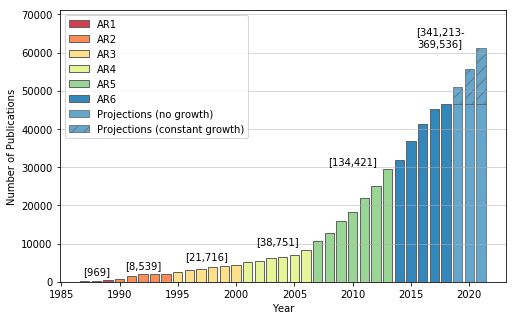

In [10]:
fig, ax = plt.subplots(figsize=(8,5))

colors = dict(zip(
    AR.objects.filter(ar__gt=0).order_by('ar').values_list('name',flat=True),
    ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd']
))


pdf = pydf[pydf['PY']>1986].sort_values('PY').reset_index(drop=True)

def CAGR(first, last, periods):
    try:
        return (last/first)**(1/periods)-1
    except:
        return np.nan
    
pdf['lag_5'] = pdf['n'].shift(5)
pdf['CAGR_5'] = pdf.apply(lambda x: CAGR(x['lag_5'], x['n'] ,5), axis=1)


ec = "#636363"
for name, group in pdf.groupby('AR'):
    group = group.reset_index(drop=True)
    ax.bar(
        group['PY'],
        group['n'],
        color=[colors[x] for x in group['AR']],
        edgecolor=ec,
        label=name
    )
    mid = group['PY'].median()
    max_n = group['n'].max() + 800
    sum_n = group['n'].sum()
    if name=="AR6":
        continue
    ax.text(mid, max_n, f"[{sum_n:,}]", ha="center", va="bottom")
    
ax.set_ylim(0,max_n+5000)
    
last_recorded = pdf['n'].iloc[-1]
last = last_recorded
grate = pdf['CAGR_5'].iloc[-1]
projections=0
ar6_total = sum_n
ar6_nogrowth = sum_n
fyears = [2019, 2020, 2021]

for py in fyears:
    if py==2019:
        name_ng = "Projections (no growth)"
        name_cg = "Projections (constant growth)"
    else:
        name_ng = None
        name_cg = None
    ax.bar(
        py,
        last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        label=name_ng,
        alpha=0.75
    )
    growth = last*grate
    projections+=growth
    ax.bar(
        py,
        projections,
        bottom=last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        hatch="//",
        label=name_cg,
        alpha=0.75
    )    
    last = last+growth
    max_n = last
    ar6_total +=last
    ar6_nogrowth +=last_recorded
    #new = last*pdf['CAGR_5'][-1]
    
print(ar6_total)

mid = pd.concat([group['PY'], pd.Series(fyears)]).median()
label = f"[{ar6_nogrowth:,}-\n{int(round(ar6_total)):,}]"
ax.text(mid, max_n, label, ha="center", va="bottom")
            
ax.set_ylim(0,max_n+10000)
ax.grid(linestyle='-', linewidth=0.5,axis="y")

ax.set_xlabel("Year")
ax.set_ylabel("Number of Publications")

plt.legend()
            
fig.patch.set_facecolor('white') 

    
plt.savefig(
    f'../plots/literature_size/pubs_time_wgb.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.savefig(
    f'../plots/literature_size/pubs_time_wbg.svg',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.show()

369535.7904682656


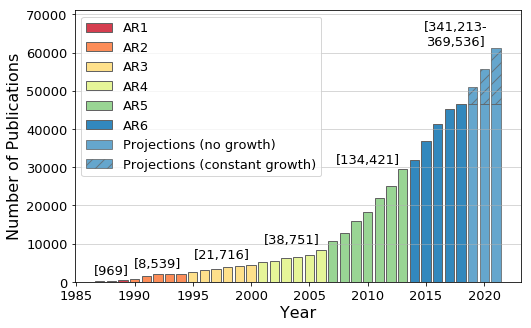

In [27]:
fig, ax = plt.subplots(figsize=(8,5))

colors = dict(zip(
    AR.objects.filter(ar__gt=0).order_by('ar').values_list('name',flat=True),
    ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd']
))

SMALL_SIZE = 13
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


pdf = pydf[pydf['PY']>1986].sort_values('PY').reset_index(drop=True)

def CAGR(first, last, periods):
    try:
        return (last/first)**(1/periods)-1
    except:
        return np.nan
    
pdf['lag_5'] = pdf['n'].shift(5)
pdf['CAGR_5'] = pdf.apply(lambda x: CAGR(x['lag_5'], x['n'] ,5), axis=1)


ec = "#636363"
for name, group in pdf.groupby('AR'):
    group = group.reset_index(drop=True)
    ax.bar(
        group['PY'],
        group['n'],
        color=[colors[x] for x in group['AR']],
        edgecolor=ec,
        label=name
    )
    mid = group['PY'].median()
    max_n = group['n'].max() + 800
    sum_n = group['n'].sum()
    if name=="AR6":
        continue
    ax.text(mid, max_n, f"[{sum_n:,}]", ha="center", va="bottom")
    
ax.set_ylim(0,max_n+5000)
    
last_recorded = pdf['n'].iloc[-1]
last = last_recorded
grate = pdf['CAGR_5'].iloc[-1]
projections=0
ar6_total = sum_n
ar6_nogrowth = sum_n
fyears = [2019, 2020, 2021]

for py in fyears:
    if py==2019:
        name_ng = "Projections (no growth)"
        name_cg = "Projections (constant growth)"
    else:
        name_ng = None
        name_cg = None
    ax.bar(
        py,
        last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        label=name_ng,
        alpha=0.75
    )
    growth = last*grate
    projections+=growth
    ax.bar(
        py,
        projections,
        bottom=last_recorded,
        color = colors['AR6'],
        edgecolor=ec,
        hatch="//",
        label=name_cg,
        alpha=0.75
    )    
    last = last+growth
    max_n = last
    ar6_total +=last
    ar6_nogrowth +=last_recorded
    #new = last*pdf['CAGR_5'][-1]
    
print(ar6_total)

mid = pd.concat([group['PY'], pd.Series(fyears)]).median()
label = f"[{ar6_nogrowth:,}-\n{int(round(ar6_total)):,}]"
ax.text(mid, max_n, label, ha="center", va="bottom")
            
ax.set_ylim(0,max_n+10000)
ax.grid(linestyle='-', linewidth=0.5,axis="y")

ax.set_xlabel("Year")
ax.set_ylabel("Number of Publications")

plt.legend()
            
fig.patch.set_facecolor('white') 
    
plt.savefig(
    f'../plots/literature_size/pubs_time_wgb_lp.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.savefig(
    f'../plots/literature_size/pubs_time_wbg_lp.svg',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.show()

In [11]:
for ar in AR.objects.filter(ar__gt=1,ar__lt=6).order_by('ar'):
    print(ar)
    irs = IPCCRef.objects.filter(ar=ar)
    docs = pdf[pdf['AR']==ar.name]['n'].sum()
    print(docs)
    print(irs.count()/docs)
    

2
8539
0.7711675840262325
3
21716
0.6460213667342052
4
38751
0.4292018270496245
5
134421
0.2575341650486159


In [12]:
pdf.head()

,PY,n,AR,lag_5,CAGR_5
0,1987,204,AR1,NaN,NaN
1,1988,253,AR1,NaN,NaN
2,1989,512,AR1,NaN,NaN
3,1990,821,AR2,NaN,NaN
4,1991,1628,AR2,NaN,NaN


In [13]:
with open("../tables/sizes_X.pickle", "rb") as f:
    X = pickle.load(f)
    
with open("../tables/vecs.pickle", "rb") as f:
    vecs = pickle.load(f)

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [14]:
with open("../tables/sizes_f_X.pickle", "rb") as f:
    f_X = pickle.load(f)
    
with open("../tables/f_vecs.pickle", "rb") as f:
    f_vecs = pickle.load(f)

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
ars = AR.objects.filter(ar__gt=0).order_by('ar').values('name','start','end')

for ar in ars:
    ar["years"] = f'{ar["start"]}-{ar["end"]}'
    if ar["name"] == "AR6":
        ar["years"] = f'{ar["start"]}-'
        
ars

<QuerySet [{'name': 'AR1', 'start': 1986, 'end': 1989, 'years': '1986-1989'}, {'name': 'AR2', 'start': 1990, 'end': 1994, 'years': '1990-1994'}, {'name': 'AR3', 'start': 1995, 'end': 2000, 'years': '1995-2000'}, {'name': 'AR4', 'start': 2001, 'end': 2006, 'years': '2001-2006'}, {'name': 'AR5', 'start': 2007, 'end': 2013, 'years': '2007-2013'}, {'name': 'AR6', 'start': 2014, 'end': 9998, 'years': '2014-'}]>

In [33]:
all_vocab = set()
ignore_vocab = set([
    'tildeo','2degreesc','5degreesc','1degreesc','0degreesc','5degrees',
    'to10','3degreesc','4degreesc','5parts','8degreesc'
])
new_vocabs = []
for i, vec in enumerate(vecs):
    x = X[i]
    vocab = vec.vocabulary_
    sum_words = x.sum(axis=0).tolist()[0]
    new_vocab = [(x[0],sum_words[x[1]]) for x in vocab.items() if x[0] not in all_vocab and x[0] not in ignore_vocab]
    new_vocab =sorted(new_vocab, key = lambda x: x[1], reverse=True)
    all_vocab = all_vocab | set(vec.get_feature_names()) - ignore_vocab
    new_vocabs.append(new_vocab[:10])
    print(new_vocab[:20])
    print('\n')

tfmt = " ".join(["p{2cm}" for x in range(7)])
tfmt = " ".join(["l" for x in range(7)])
tfmt = "l |" + " ".join(["p{1.8cm}" for x in range(6)])
hrow = "&" + " & ".join([f"\\textbf{{{x.name}}}" for x in AR.objects.filter(ar__gt=0).order_by('ar')]) + "\\\\ \hline"
drow = "\\textbf{Documents} &" +" & ".join([f'{x.shape[0]:,}' for x in X]) + "\\\\ \n"
wrow = "\\textbf{Unique words} &" +" & ".join([f'{x.shape[1]:,}' for x in X]) + "\\\\ \n"
#nwrow = "\\textbf{Words} &" + " & ".join([str(x) for x in new_vocabs]) 
nwrows = "\\textbf{New words}" + "\\\\".join([" & " + " & ".join([f"{x[i][0]} ({x[i][1]:,})" for x in new_vocabs]) for i in range(8)])
print(hrow) 

with open("../tables/growth_table.tex","w") as f:
    f.write("\\begin{tabular}{|" + tfmt + "|} \n")
    f.write('\\hline \n')
    f.write(hrow)
    f.write(yrow)
    f.write(drow)
    f.write(wrow)
    f.write(nwrows)
    f.write(" \\\\ \hline")
    f.write("\n\\end{tabular}")
## MMMs = Mixed matrix membrane
nwrows

[('change', 560), ('climate', 428), ('co2', 318), ('climatic', 289), ('model', 288), ('atmospheric', 281), ('effect', 280), ('global', 224), ('carbon', 201), ('ocean', 198), ('greenhouse', 188), ('temperature', 178), ('surface', 155), ('water', 152), ('sea', 151), ('methane', 150), ('ice', 145), ('use', 142), ('increase', 139), ('time', 124)]


[('oil', 287), ('deltac', 283), ('whole', 256), ('tax', 254), ('landscape', 249), ('alternative', 243), ('availability', 242), ('life', 239), ('top', 239), ('far', 223), ('understand', 220), ('scheme', 218), ('carry', 209), ('altitude', 208), ('elevation', 207), ('begin', 199), ('possibility', 198), ('decomposition', 197), ('emit', 193), ('removal', 189)]


[('downscaling', 217), ('degreesc', 187), ('ncep', 130), ('fco', 107), ('pfc', 98), ('otcs', 98), ('dtr', 95), ('nee', 89), ('hadcm2', 82), ('annex', 79), ('aij', 77), ('fuzzy', 73), ('cdm', 72), ('vpd', 69), ('earthworm', 64), ('oeschger', 62), ('boreas', 61), ('coconut', 57), ('estonia', 56

'\\textbf{New words} & change (560) & oil (287) & downscaling (217) & sres (234) & biochar (1,791) & mmms (313)\\\\ & climate (428) & deltac (283) & degreesc (187) & petm (95) & redd (1,113) & cop21 (234)\\\\ & co2 (318) & whole (256) & ncep (130) & amf (88) & cmip5 (679) & c3n4 (214)\\\\ & climatic (289) & tax (254) & fco (107) & sf5cf3 (86) & cmip3 (587) & sdg (187)\\\\ & model (288) & landscape (249) & pfc (98) & clc (81) & mofs (299) & zika (182)\\\\ & atmospheric (281) & alternative (243) & otcs (98) & embankment (81) & sdm (297) & ndcs (168)\\\\ & effect (280) & availability (242) & dtr (95) & cwd (79) & mof (275) & indc (164)\\\\ & global (224) & life (239) & nee (89) & etm (75) & biochars (252) & indcs (134)'

In [25]:
all_vocab = set()
ignore_vocab = set([
    'tildeo','2degreesc','5degreesc','1degreesc','0degreesc','5degrees',
    'to10','3degreesc','4degreesc','5parts','8degreesc'
])
new_vocabs = []
for i, vec in enumerate(vecs):
    x = X[i]
    vocab = vec.vocabulary_
    sum_words = x.sum(axis=0).tolist()[0]
    new_vocab = [(x[0],sum_words[x[1]]) for x in vocab.items() if x[0] not in all_vocab and x[0] not in ignore_vocab]
    new_vocab =sorted(new_vocab, key = lambda x: x[1], reverse=True)
    all_vocab = all_vocab | set(vec.get_feature_names()) - ignore_vocab
    new_vocabs.append(new_vocab[:10])
    print(new_vocab[:20])
    print('\n')

tfmt = " ".join(["p{3cm}" for x in range(7)])
tfmt = " ".join(["l" for x in range(7)])
tfmt = "l " + " ".join(["p{2.8cm}" for x in range(6)])
hrow = "&" + " & ".join([f"\\textbf{{{x.name}}}" for x in AR.objects.filter(ar__gt=0).order_by('ar')]) + "\\\\ \hline"
drow = "\\textbf{Documents} &" +" & ".join([str(x.shape[0]) for x in X]) + "\\\\ \n"
wrow = "\\textbf{Unique words} &" +" & ".join([f'{x.shape[1]:,}' for x in X]) + "\\\\ \n"
#nwrow = "\\textbf{Words} &" + " & ".join([str(x) for x in new_vocabs]) 
nwrows = "\\textbf{New words}" + "\\\\".join([" & " + " & ".join([f"{x[i][0]} ({x[i][1]:,})" for x in new_vocabs]) for i in range(8)])
print(hrow) 

with open("../tables/growth_table_large.tex","w") as f:
    f.write("\\begin{tabular}{" + tfmt + "} \n")
    f.write(hrow)
    f.write(drow)
    f.write(wrow)
    f.write(nwrows)
    f.write("\n\\end{tabular}")
## MMMs = Mixed matrix membrane
nwrows

[('change', 560), ('climate', 428), ('co2', 318), ('climatic', 289), ('model', 288), ('atmospheric', 281), ('effect', 280), ('global', 224), ('carbon', 201), ('ocean', 198), ('greenhouse', 188), ('temperature', 178), ('surface', 155), ('water', 152), ('sea', 151), ('methane', 150), ('ice', 145), ('use', 142), ('increase', 139), ('time', 124)]


[('oil', 287), ('deltac', 283), ('whole', 256), ('tax', 254), ('landscape', 249), ('alternative', 243), ('availability', 242), ('life', 239), ('top', 239), ('far', 223), ('understand', 220), ('scheme', 218), ('carry', 209), ('altitude', 208), ('elevation', 207), ('begin', 199), ('possibility', 198), ('decomposition', 197), ('emit', 193), ('removal', 189)]


[('downscaling', 217), ('degreesc', 187), ('ncep', 130), ('fco', 107), ('pfc', 98), ('otcs', 98), ('dtr', 95), ('nee', 89), ('hadcm2', 82), ('annex', 79), ('aij', 77), ('fuzzy', 73), ('cdm', 72), ('vpd', 69), ('earthworm', 64), ('oeschger', 62), ('boreas', 61), ('coconut', 57), ('estonia', 56

'\\textbf{New words} & change (560) & oil (287) & downscaling (217) & sres (234) & biochar (1,791) & mmms (313)\\\\ & climate (428) & deltac (283) & degreesc (187) & petm (95) & redd (1,113) & cop21 (234)\\\\ & co2 (318) & whole (256) & ncep (130) & amf (88) & cmip5 (679) & c3n4 (214)\\\\ & climatic (289) & tax (254) & fco (107) & sf5cf3 (86) & cmip3 (587) & sdg (187)\\\\ & model (288) & landscape (249) & pfc (98) & clc (81) & mofs (299) & zika (182)\\\\ & atmospheric (281) & alternative (243) & otcs (98) & embankment (81) & sdm (297) & ndcs (168)\\\\ & effect (280) & availability (242) & dtr (95) & cwd (79) & mof (275) & indc (164)\\\\ & global (224) & life (239) & nee (89) & etm (75) & biochars (252) & indcs (134)'

In [18]:
## parse the bible, turn it into same format
import codecs
import re
bible = []
i=0
clines=""
corpus = []
lchapter="none"
with codecs.open('/home/galm/projects/big_literature/py/Martin_Luther_Uebersetzung_1912.txt',encoding = "ISO-8859-1") as ml:
    for line in ml:
        chapter = line.split(':')[0]
        try:
            verse = re.search(".*([0-9]+\:[0-9]*)(.*)",line).group(2).strip()
        except:
            corpus.append(str(clines))
            break
        if lchapter!=chapter and i > 0:
            corpus.append(str(clines))
            clines=verse            
        else:
            clines+=" "+verse
            #print('\n')
        lchapter = chapter
        i+=1
        
X_y = c_vectorizer.fit_transform(corpus)
X.append(X_y)

NameError: name 'c_vectorizer' is not defined

In [ ]:
ind = np.arange(1)

def vvrect(X,col_x,m):
    return plt.bar(ind+X.shape[1]/2,X.shape[0],width=X.shape[1],facecolor=col_x,edgecolor='black',alpha=m)#,alpha=m)

means = [x.getnnz(0).mean()/x.shape[0]*100 for x in X]
nmeans = normalize([means])[0]

crange = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']

crange = ["#D53E4F", "#FC8D59", "#FEE08B", "#E6F598", "#99D594", "#3288BD"]

crange = ["#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462","grey"]

years = [x.name for x in ars] + ["Bible"]

fig = plt.figure()

plots = []
lvalues = []
for x in [5,4,3,2,1,0,6]:
    a = (nmeans[x]+0.3)/1.3
    #a = nmeans[x]
    vvrect(X[x], "None",1)
    vvrect(X[x], "white",1)
    p = vvrect(X[x], crange[x] ,a)
    plots.append(p[0])
    lvalues.append(years[x] + ": " + str(round(means[x],2)))
    print(crange[5-x])
    print(a)
    
plt.legend(plots,lvalues,title='% of documents mean\nterm appears in')
    
plt.axis('equal')
plt.ylabel('Documents')
plt.xlabel('Words')
fig.patch.set_facecolor('#f0f0f0')    
#plt.tight_layout()

plt.savefig(
    '../plots/literature_size/volume_variety.pdf',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
)

plt.show()


In [ ]:
tab = pd.DataFrame([(x.shape[0],x.shape[1]) for x in X]).rename({0:'Documents',1:'Terms'},axis="columns")
tab.index = years
tab['Average Document score per Term'] = means
tab

In [ ]:

shape = [(x+6000)/10000 for x in list(X[5].shape)[::1]]

#plt.rcParams["figure.figsize"] = tuple([round(x) for x in shape[::1]])

#plt.rcParams["figure.figsize"] = (9.5,13)

xs = [5,4,3,2,1,0,6]

for ar in AR.objects.all():
    
    iprs = IPCCRef.objects.filter(ar=ar).count()
    
    plots = []
    lvalues = []

    ar_xs = [x for x in xs if ar.ar > x ]
    print(ar_xs)
    #continue
    for x in ar_xs:
        a = (nmeans[x]+0.1)/1.1
        #a = nmeans[x]
        vvrect(X[x], "None",1)
        vvrect(X[x], "white",1)
        p = vvrect(X[x], crange[x] ,a)
        plots.append(p[0])
        lvalues.append(years[x] + ": " + str(round(means[x],2)))
        ar = AR.objects.get(ar=x+1)
        iprs = IPCCRef.objects.filter(ar=ar).count()
        xtent = shape[1]*10000+5000+1000
        #plt.axhline(iprs,xmin=1/xtent*1000,xmax=1/xtent*(X[x].shape[1]+1000))
    
    plt.legend(plots,lvalues,title='% of documents mean term appears in')
    
    #plt.axis('equal')

    #plt.ylim((-1000,130000))
    #plt.ylim(ymin=-1000)
    #plt.xlim((-1000,100000))
    plt.xlim((-1000,shape[1]*10000+5000))
    plt.ylim((-1000,shape[0]*10000+5000))
    #plt.ylim(ymax=shape[0]*10000)
    #plt.xlim(xmax=shape[1]*10000)
    plt.ylabel('Documents')
    plt.xlabel('Words')
    plt.savefig('../plots/literature_size/volume_variety_{}.pdf'.format(ar.name),bbox_inches='tight')
    
    print(plt.xlim())

    plt.show()


In [ ]:
for ar in ars:
    plots = []
    lvalues = []

    ar_xs = [x for x in xs if ar.ar > x or x ==6]
    print(ar_xs)
    #continue
    for x in ar_xs:
        a = (nmeans[x]+0.1)/1.1
        #a = nmeans[x]
        vvrect(X[x], "None",1)
        vvrect(X[x], "white",1)
        p = vvrect(X[x], crange[x] ,a)
        plots.append(p[0])
        #lvalues.append(years[x] + ": " + str(round(X[x].mean()*1000000/X[x].sum(),5)))
        lvalues.append(years[x] + ": " + str(round(means[x],2)))
        print(crange[5-x])
        print(a)
    
    plt.legend(plots,lvalues,title='% of documents mean term appears in')
    
    #plt.axis('equal')

    #plt.ylim((-1000,130000))
    #plt.ylim(ymin=-1000)
    #plt.xlim((-1000,100000))
    plt.xlim((-1000,shape[1]*10000+5000))
    plt.ylim((-1000,shape[0]*10000+5000))
    #plt.ylim(ymax=shape[0]*10000)
    #plt.xlim(xmax=shape[1]*10000)
    plt.ylabel('Documents')
    plt.xlabel('Words')
    plt.savefig('../plots/literatures_size/volume_variety_bible_{}.pdf'.format(ar.name),bbox_inches='tight')
    
    print(plt.xlim())

    plt.show()



In [ ]:
means

nmeans

In [ ]:
for x in xs:
    print(X[x].sum(0).mean())
    print(X[x].sum(0).mean()/X[x].shape[0]*100)
    print(X[x].shape)
    print('\n\n')
    
    

In [ ]:
for x in xs:
    print(X[x].getnnz(0).mean())
    print(X[x].getnnz(0).mean()/X[x].shape[0]*100)
    print(X[x].shape)
    print('\n\n')
    

In [ ]:
X_y.sum(0).mean()
